In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.utils import class_weight
from keras.datasets import fashion_mnist
from keras.models import Sequential,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Dense, Conv2D,Flatten, AveragePooling2D, AveragePooling3D
from sys import getsizeof

Using TensorFlow backend.


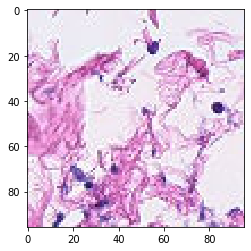

In [2]:
# example image

arr = plt.imread('0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif')
arr.shape

plt.imshow(arr)
plt.show()

# 1. Load data

In [3]:
def subset(length,frac=0.25):
    '''This function permits to load a subset of data'''
    newlength=int(frac*length)
    idchoice=np.random.choice(np.arange(0,length),size=newlength,replace=False)
    return idchoice

In [4]:
# read labels

df_train_labels = pd.read_csv('data/train_labels.csv')

X = []
y = []
#X = np.array(X)
counter=0
tot_sample = len(df_train_labels)


subsetid = subset(tot_sample,frac=1)
subset_data = len(subsetid)
counter = 0

for i in subsetid:
    fname = df_train_labels.loc[i,'id']
    arr = plt.imread('data/train/'+str(fname)+'.tif')
    X.append(arr)
    y.append(df_train_labels.loc[i,'label'])
    #X = np.append(X,arr)
    counter = counter+1
    if (counter % int(subset_data/100)) == 0:
        print('complete',counter/int(subset_data/100),'%')

complete 1.0 %
complete 2.0 %
complete 3.0 %
complete 4.0 %
complete 5.0 %
complete 6.0 %
complete 7.0 %
complete 8.0 %
complete 9.0 %
complete 10.0 %
complete 11.0 %
complete 12.0 %
complete 13.0 %
complete 14.0 %
complete 15.0 %
complete 16.0 %
complete 17.0 %
complete 18.0 %
complete 19.0 %
complete 20.0 %
complete 21.0 %
complete 22.0 %
complete 23.0 %
complete 24.0 %
complete 25.0 %
complete 26.0 %
complete 27.0 %
complete 28.0 %
complete 29.0 %
complete 30.0 %
complete 31.0 %
complete 32.0 %
complete 33.0 %
complete 34.0 %
complete 35.0 %
complete 36.0 %
complete 37.0 %
complete 38.0 %
complete 39.0 %
complete 40.0 %
complete 41.0 %
complete 42.0 %
complete 43.0 %
complete 44.0 %
complete 45.0 %
complete 46.0 %
complete 47.0 %
complete 48.0 %
complete 49.0 %
complete 50.0 %
complete 51.0 %
complete 52.0 %
complete 53.0 %
complete 54.0 %
complete 55.0 %
complete 56.0 %
complete 57.0 %
complete 58.0 %
complete 59.0 %
complete 60.0 %
complete 61.0 %
complete 62.0 %
complete 63.0 %
c

# 2. Exploratory Data Analysis

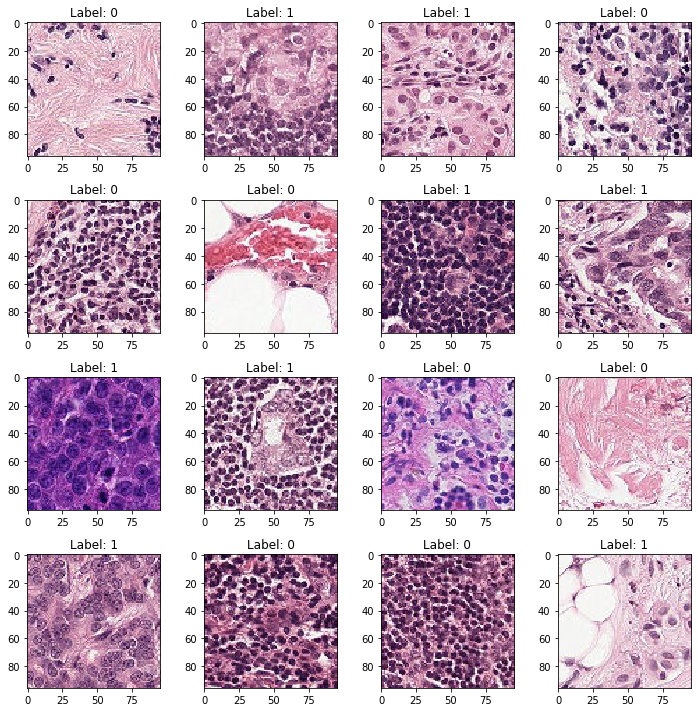

In [5]:
# show some images

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X[i])
    plt.title('Label: '+str(y[i]))
plt.tight_layout()
plt.savefig('results/someimage_input.png',dpi=300)
plt.show()

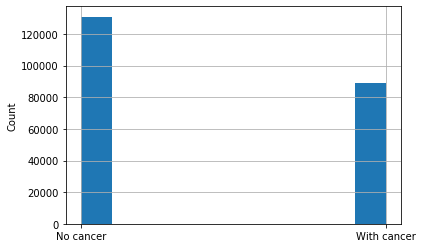

In [6]:
# Distribution of 0 (no cancer) and 1 (cancer)

plt.hist(y)
plt.grid()
plt.ylabel('Count')
plt.xticks([0,1],['No cancer','With cancer'])
plt.show()

In [7]:
def sample_vectors(X,y,size=0.1):
    '''This function permits to create a sub-sample of the original tensor'''
    newlen=int(size*len(X))
    newX=np.array(X[0:newlen])
    newy=np.array(y[0:newlen])
    return newX,newy

In [8]:
X_red,y_red = sample_vectors(X,y,size=0.01)

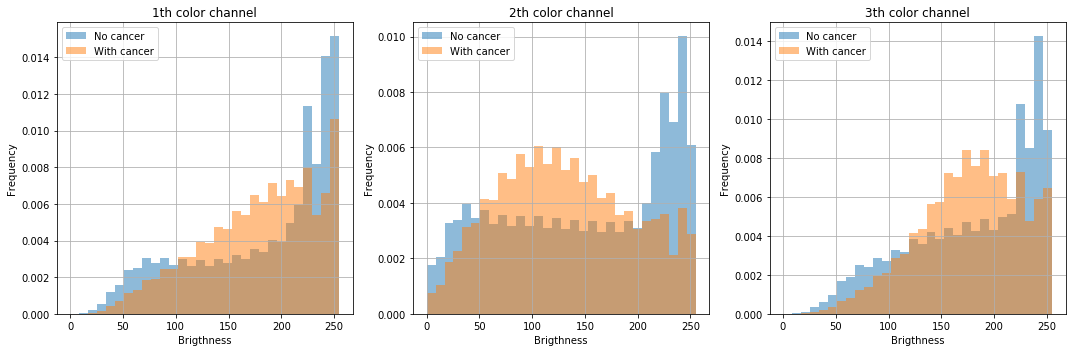

In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.ndarray.flatten(X_red[y_red==0,:,:,0]),bins=30,density=True,alpha=0.5,label='No cancer')
plt.hist(np.ndarray.flatten(X_red[y_red==1,:,:,0]),bins=30,density=True,alpha=0.5,label='With cancer')
plt.xlabel('Brigthness')
plt.ylabel('Frequency')
plt.legend()
plt.title('1th color channel')
plt.grid()
plt.subplot(1,3,2)
plt.hist(np.ndarray.flatten(X_red[y_red==0,:,:,1]),bins=30,density=True,alpha=0.5,label='No cancer')
plt.hist(np.ndarray.flatten(X_red[y_red==1,:,:,1]),bins=30,density=True,alpha=0.5,label='With cancer')
plt.xlabel('Brigthness')
plt.ylabel('Frequency')
plt.legend()
plt.title('2th color channel')
plt.grid()
plt.subplot(1,3,3)
plt.hist(np.ndarray.flatten(X_red[y_red==0,:,:,2]),bins=30,density=True,alpha=0.5,label='No cancer')
plt.hist(np.ndarray.flatten(X_red[y_red==1,:,:,2]),bins=30,density=True,alpha=0.5,label='With cancer')
plt.xlabel('Brigthness')
plt.ylabel('Frequency')
plt.legend()
plt.title('3th color channel')
plt.grid()
plt.tight_layout()
plt.savefig('results/bright_comparison.png',dpi=300)
plt.show()

In [10]:
#print('Dimension occuped by the array X:',round(X.nbytes*10**-9,1),'Gb')

# 3. Machine Learning section

### Preparing data for ML

In [11]:
subdim=200000

X_test = np.array(X[subdim:])
y_test = np.array(y[subdim:])

valid_size = 0.2
split_point = int(valid_size*subdim)

X_train = np.array(X[split_point:subdim])
y_train = np.array(y[split_point:subdim])
X_valid  = np.array(X[0:split_point])
y_valid  = np.array(y[0:split_point])

In [12]:
print('Dimension occuped by the array X_train:',round(X_train.nbytes*10**-9,1),'Gb')
print('Dimension occuped by the array X_valid:',round(X_valid.nbytes*10**-9,1),'Gb')

#del(X)

#X_train

Dimension occuped by the array X_train: 4.4 Gb
Dimension occuped by the array X_valid: 1.1 Gb


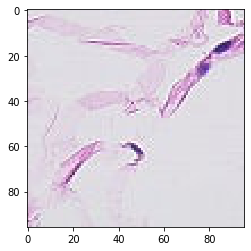

In [13]:
# check image

plt.imshow(X_train[0,:])
plt.show()

In [14]:
class_weights=class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)

print(class_weights)

[0.84094564 1.23325471]


In [15]:
#pre_load_model = load_model('results/best_model.hdf5')
#pre_load_weights = np.array(pre_load_model.get_weights())

### Setup of the convolutional Neural Network

In [29]:
def pallad_biglenet5(input_shape=(96,96, 3), output=1 , epochs=50, patience=10, pre_load_weights='no'):
    
    # initialize sequential model
    model = Sequential()

    # add 1th hidden (convolutional) layer with 6 neurons
    # the application of the kernel 5x5 reduces the dimension of the matrix from 96x96 to 92x92
    # the strides=2 further reduces the dimension from 92x92 to 46x46
    model.add(Conv2D(filters=24, kernel_size=(5,5),strides=2, activation='relu', input_shape=input_shape))
    # reduce dimension of the image from 46x46 to 23x23
    model.add(AveragePooling2D())

    # add 2th hidden (convolutional) layer with 16 neurons
    # the application of the kernel 4x4 reduces the dimension of the image from 23x23 to 20x20
    # the sdrides=2 further reduces the dimension to 10x10
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=2, activation='relu'))
    # reduce dimension of the image from 10x10 to 5x5
    model.add(AveragePooling2D())
    

    # flatten the previous layers, obtaining a vector of dimension 5x5x16, as in Lenet5
    # i.e. (last dimension of the matrix, 5x5) x (number of neurons of the last hidden layer, 16)
    model.add(Flatten())

    # add 3th hidden (dense) layer with 120 neurons
    model.add(Dense(units=480, activation='relu'))
    # dropout randomly 50% of nodes. This helps to avoid overfitting
    model.add(Dropout(0.5))
  
    # add 4th hidden (dense) layer with 84 neurons
    model.add(Dense(units=336, activation='relu'))
    model.add(Dropout(0.4))

    # add the output layer, with 10 neurons
    model.add(Dense(units=output, activation='sigmoid'))

    # monitors
    # stop the training if the validation accuracy does not improve after a certain number of epochs (defined by patience)
    early_stopping_monitor = EarlyStopping(patience=patience,monitor='val_accuracy')
    # save the model with the best validation accuracy
    model_checkpoint_callback = ModelCheckpoint(filepath='results/best_model.hdf5',save_weights_only=False,monitor='val_accuracy',
    mode='auto',save_best_only=True,verbose=1)
    
    
    # compile model
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

    print(model.summary())
    
    # fit model
    history = model.fit(X_train,y_train,
          batch_size=1600, epochs=epochs,
          callbacks=[early_stopping_monitor,model_checkpoint_callback],validation_data=(X_valid,y_valid),class_weight=class_weights)
    
    # computing the test accuracy
    trained_model=load_model('results/best_model.hdf5')      # load the best model

    valid_acc = round(np.max(history.history['val_accuracy']),3)
    print('the maximum validation accuracy is ',valid_acc)
    
    return trained_model , valid_acc, history

In [30]:
peppe = pallad_biglenet5(epochs=100,patience=10)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 46, 46, 24)        1824      
_________________________________________________________________
average_pooling2d_5 (Average (None, 23, 23, 24)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 64)        24640     
_________________________________________________________________
average_pooling2d_6 (Average (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 480)               768480    
_________________________________________________________________
dropout_5 (Dropout)          (None, 480)              

160000/160000 [==============================] - 133s 828us/step - loss: 0.4279 - accuracy: 0.8043 - val_loss: 0.4589 - val_accuracy: 0.7946

Epoch 00028: val_accuracy did not improve from 0.79937
Epoch 29/100
160000/160000 [==============================] - 133s 830us/step - loss: 0.4228 - accuracy: 0.8069 - val_loss: 0.4397 - val_accuracy: 0.8079

Epoch 00029: val_accuracy improved from 0.79937 to 0.80790, saving model to results/best_model.hdf5
Epoch 30/100
160000/160000 [==============================] - 132s 827us/step - loss: 0.4158 - accuracy: 0.8107 - val_loss: 0.4308 - val_accuracy: 0.8111

Epoch 00030: val_accuracy improved from 0.80790 to 0.81112, saving model to results/best_model.hdf5
Epoch 31/100
160000/160000 [==============================] - 133s 829us/step - loss: 0.4080 - accuracy: 0.8156 - val_loss: 0.4551 - val_accuracy: 0.7969

Epoch 00031: val_accuracy did not improve from 0.81112
Epoch 32/100
160000/160000 [==============================] - 133s 829us/step - los

In [31]:
# number of nodes used in the Neural Network
#n_nodes = np.array([6,16,120,84,1])
n_nodes = np.array([24,64,480,336,1])

# get total number of weights per layer
def get_nofweights(n_nodes):
    ly1=3*n_nodes[0]*5*5+n_nodes[0]
    ly2=n_nodes[0]*n_nodes[1]*4*4+n_nodes[1]
    ly3=5*5*n_nodes[1]*n_nodes[2]+n_nodes[2]
    ly4=n_nodes[2]*n_nodes[3]+n_nodes[3]
    ly5=n_nodes[3]*n_nodes[4]+n_nodes[4]
    return ly1+ly2+ly3+ly4+ly5

# get number of weights of the current architecture
get_nofweights(n_nodes)

956897

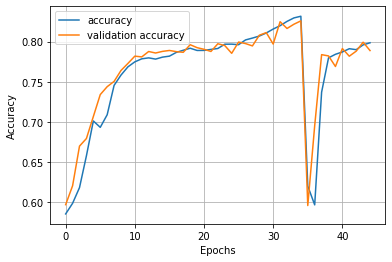

In [43]:
plt.plot(peppe[2].history['accuracy'],label='accuracy')
plt.plot(peppe[2].history['val_accuracy'],label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig('results/historyNN.png',dpi=300)
plt.show()

# 4. Analysis of results

In [33]:
modello = load_model('results/best_model.hdf5')

In [34]:
y_pred_test = modello.predict(X_test)
y_pred_test_int = np.around(y_pred_test[:,0]).astype(int)

In [40]:
roc_score=round(roc_auc_score(y_test,y_pred_test[:,0]),2)

print('The roc_auc score on unseen data is',roc_score)

The roc_auc score on unseen data is 0.9


### check the performance using test images 

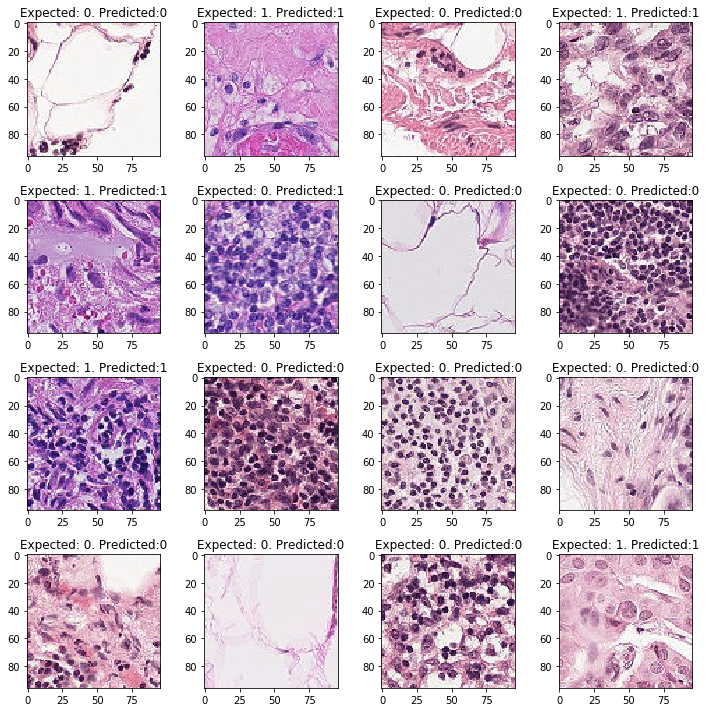

In [44]:
# show some images

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_test[i,:])
    plt.title('Expected: '+str(y_test[i])+'. Predicted:'+str(y_pred_test_int[i]))
plt.tight_layout()
plt.savefig('results/someimage_results.png',dpi=300)
plt.show()